### 1 사진 준비

In [2]:
import cv2
import os
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

print('슝=3')

슝=3


이미지 크기: (450, 800, 3)


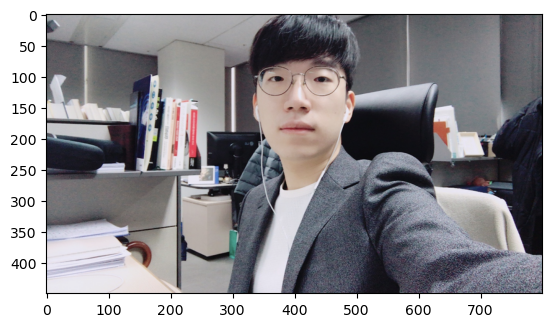

In [3]:
home_dir = os.getenv('HOME')
img_path = os.path.join(home_dir, "work/human_segmentation/images/my_image.png")
img_orig = cv2.imread(img_path)

print(f"이미지 크기: {img_orig.shape}")

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

### 2. Segmentation(피사체 분리)
- Semamtic segmentation: 물리적 의미 단위로 분류
- Instance Segmentation: 사람 등 추상적 정보로 이미지 추출한다면 인스턴스 세그멘테이션은 여라사람이 한 이미지에 등장할때 각 객체를 분할하여 인식하는 것

#### 2.1 시맨틱 세그멘테이션
- Atrous convolution은 기존 convolution과 다르게, 필터 내부에 빈 공간을 둔 채로 작동
- 파라미터인 rate r=1일 경우, 기존 convolution과 동일하고, r이 커질 수록, 빈 공간이 넓어짐
- Atrous convolution을 활용함으로써 얻을 수 있는 이점은, 기존 convolution과 동일한 양의 파라미터와 계산량을 유지하면서도, 
- field of view (한 픽셀이 볼 수 있는 영역) 또는 receptive field를 넓게 사용 가능.
- Atrous convolution을 활용하면 파라미터 수를 늘리지 않으면서도 receptive field를 크게 키울 수 있기 때문에 DeepLab series에서는 이를 적극적으로 활용하려고 함

- Semantic segmentaion의 성능을 높이기 위한 방법 중 하나로, spatial pyramid pooling 기법이 자주 활용되고 있는 추세
- DeepLab V2에서는 feature map으로부터 여러 개의 rate가 다른 atrous convolution을 병렬로 적용한 뒤, 이를 다시 합쳐주는 atrous spatial pyramid pooling (ASPP) 기법 활용

In [4]:
# DeepLab 모델을 준비
model = deeplabv3_resnet101(pretrained=True).eval()

/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# 이미지 처리
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기 (고정)
    T.ToTensor(),
])

In [6]:
# 전처리
input_tensor = transform(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)).unsqueeze(0)

In [7]:
%%time

# 모델에 이미지 입력
with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

# 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (img_orig.shape[1], img_orig.shape[0]), interpolation=cv2.INTER_NEAREST)

CPU times: user 10 s, sys: 197 ms, total: 10.2 s
Wall time: 10.4 s


In [8]:
#  PASCAL VOC 데이터로 학습된 모델

#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES) # 백그라운드를 제외하면 20개

21

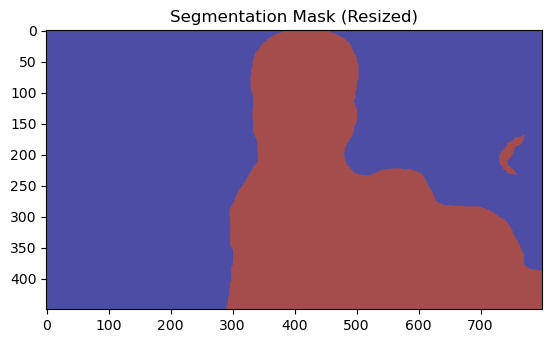

In [9]:
plt.imshow(output_predictions_resized, cmap="jet", alpha=0.7)
plt.title("Segmentation Mask (Resized)")
plt.show()

In [10]:
unique_classes = np.unique(output_predictions_resized)
unique_classes

array([ 0, 15], dtype=uint8)

In [11]:
for class_id in unique_classes:
    print(LABEL_NAMES[class_id])

background
person


In [12]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생성 코드 결과물이예요!

#컬러맵 만들기
colormap = np.zeros((256, 3), dtype=int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]  # 생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [13]:
colormap[15] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

array([192, 128, 128])

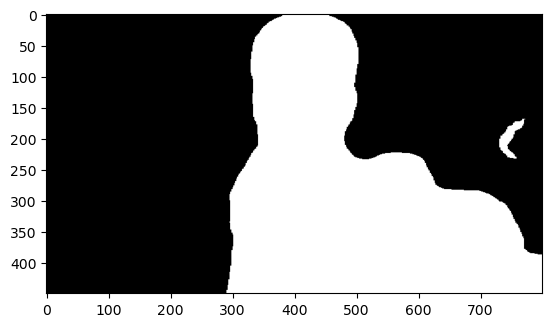

In [14]:
# output의 픽셀 별로 예측된 class가 사람이라면 1(True), 다르다면 0(False)이 됩니다
# 1과 0에 각각 255를 곱하였으므로 사람으로 예측된 픽셀은 255, 그렇지 않은 픽셀은 0
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = (output_predictions_resized == 15)  # 클래스 ID 15 (사람)
img_mask = seg_map.astype(np.uint8) * 255  # 255 값으로 변환
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

plt.imshow(img_mask, cmap='gray')  # 흑백으로 표시
plt.show()

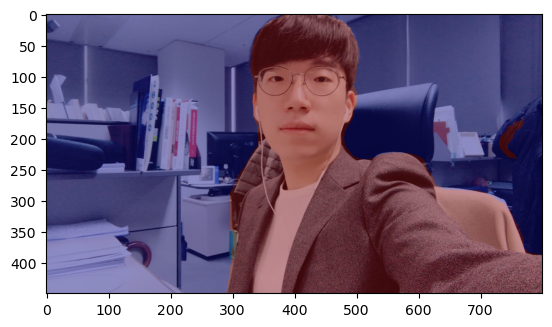

In [15]:
# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.

img_show = cv2.addWeighted(img_orig, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 3. 배경 흐리게 하기

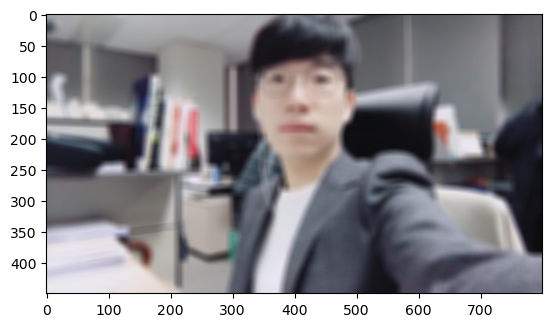

In [16]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13, 13))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

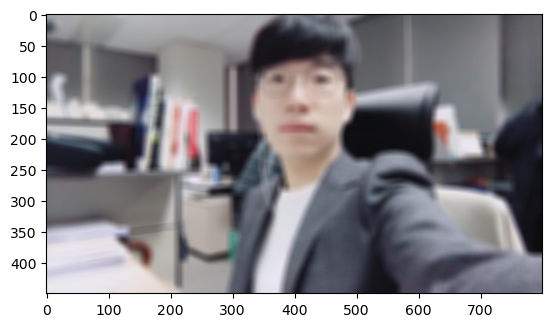

In [17]:
img_orig_blur2 = cv2.blur(img_orig, (100, 100))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

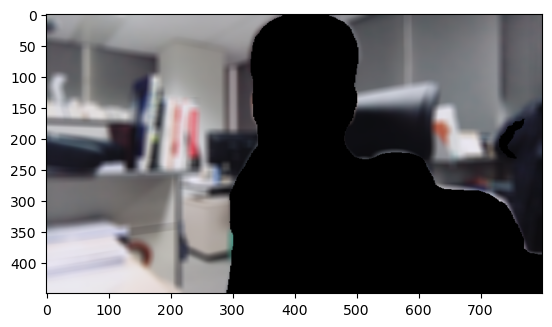

In [18]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

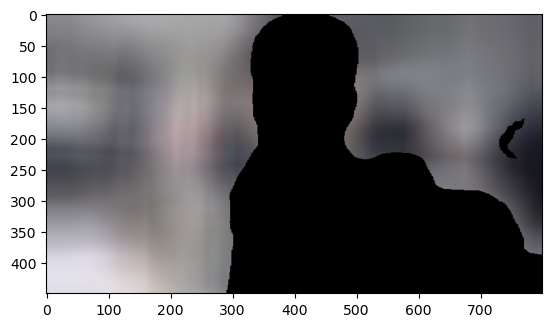

In [19]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# bitwise_not 함수를 사용하면 이미지 반전됨, 연산후 사람이 255 -> 0이 됨.
img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur2 = cv2.bitwise_and(img_orig_blur2, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur2, cv2.COLOR_BGR2RGB))
plt.show()

### 4. 흐린 배경과 원본 영상 합성

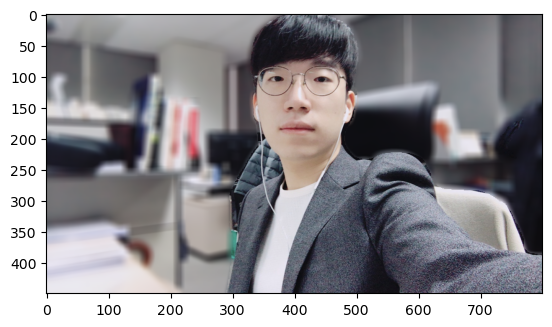

In [20]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

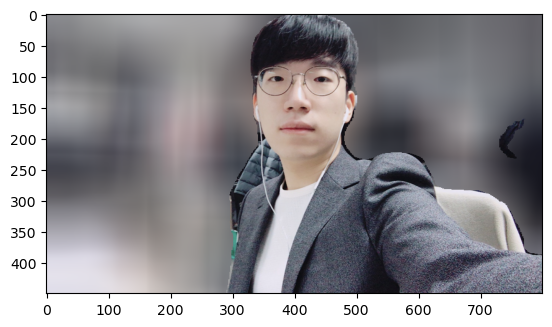

In [21]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur2)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

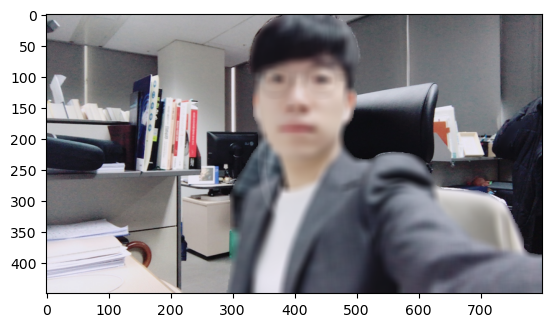

In [22]:
# Q. 이번에는 사람 부분을 블러로, 배경 부분을 원본으로 출력해볼까요?
# 힌트 : img_mask_color 옵션을 적절히 조정해주고, img_orig, img_orig_blur 를 활용하세요.
img_concat = np.where(img_mask_color == 255, img_orig_blur, img_orig)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

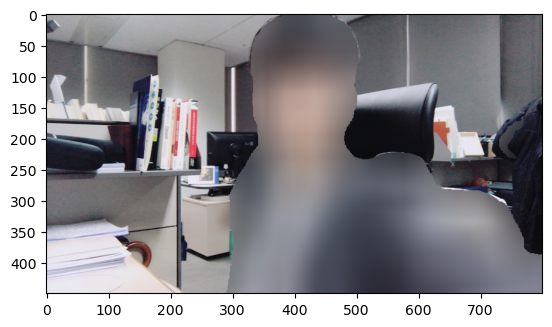

In [23]:
img_concat = np.where(img_mask_color == 255, img_orig_blur2, img_orig)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 5. 프로젝트 직접 해보기

cat_1 크기: (456, 616, 3)
cat_2 크기: (541, 857, 3)
cat_3 크기: (513, 876, 3)
sand 크기: (428, 711, 3)


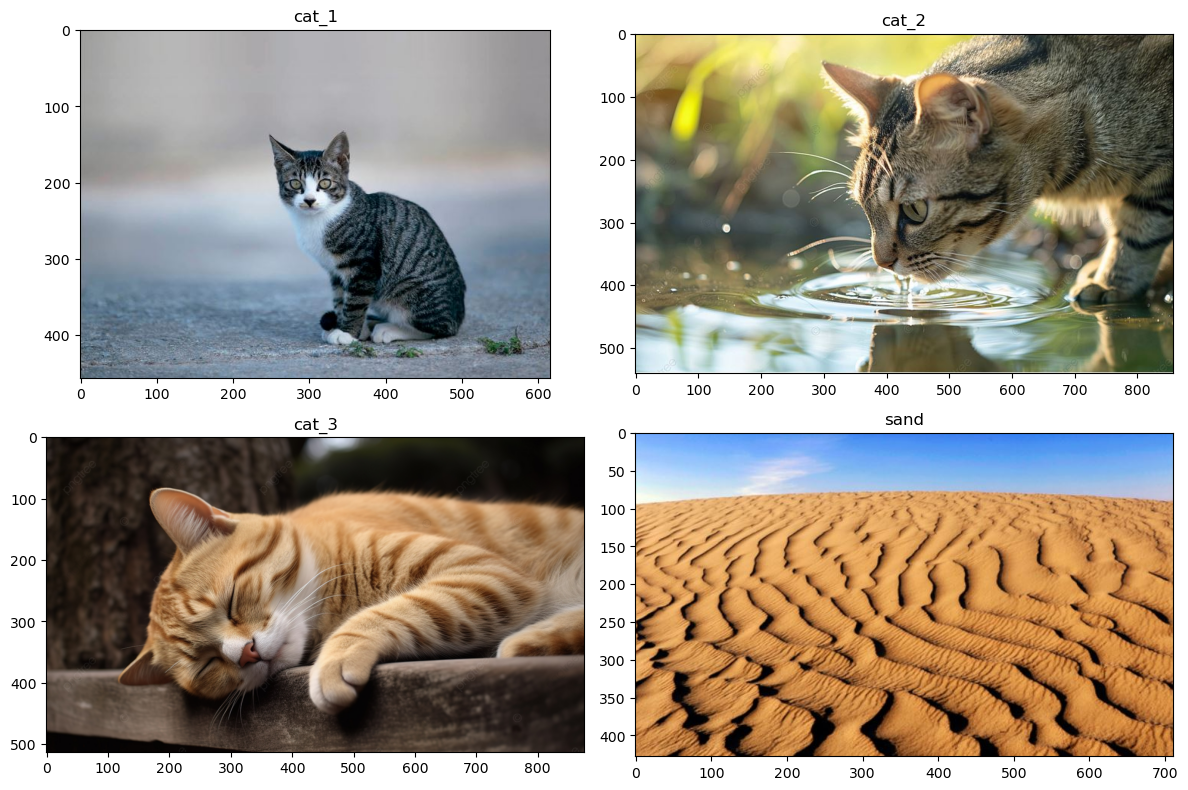

In [24]:
# 이미지 불러오기
cat_img_path1 = os.path.join(home_dir, "work/human_segmentation/images/cat_1.JPG")
cat_img_path2 = os.path.join(home_dir, "work/human_segmentation/images/cat_2.JPG")
cat_img_path3 = os.path.join(home_dir, "work/human_segmentation/images/cat2.png")
sand_img_path = os.path.join(home_dir, "work/human_segmentation/images/sand.JPG") 

 # 이미지 로딩
cat_img1 = cv2.imread(cat_img_path1)
cat_img2 = cv2.imread(cat_img_path2)
cat_img3 = cv2.imread(cat_img_path3)
sand_img = cv2.imread(sand_img_path)

# RGB 변환
cat_img1 = cv2.cvtColor(cat_img1, cv2.COLOR_BGR2RGB)
cat_img2 = cv2.cvtColor(cat_img2, cv2.COLOR_BGR2RGB)
cat_img3 = cv2.cvtColor(cat_img3, cv2.COLOR_BGR2RGB)
sand_img = cv2.cvtColor(sand_img, cv2.COLOR_BGR2RGB)

# 크기 출력
print(f"cat_1 크기: {cat_img1.shape}")
print(f"cat_2 크기: {cat_img2.shape}")
print(f"cat_3 크기: {cat_img3.shape}")
print(f"sand 크기: {sand_img.shape}")

# 이미지 4장 시각화
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.imshow(cat_img1)
plt.title("cat_1")

plt.subplot(2, 2, 2)
plt.imshow(cat_img2)
plt.title("cat_2")

plt.subplot(2, 2, 3)
plt.imshow(cat_img3)
plt.title("cat_3")

plt.subplot(2, 2, 4)
plt.imshow(sand_img)
plt.title("sand")

plt.tight_layout()
plt.show()

In [25]:
model = deeplabv3_resnet101(pretrained=True).eval()

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기
    T.ToTensor(),
])

input_tensor1 = transform(cat_img1).unsqueeze(0)
input_tensor2 = transform(cat_img2).unsqueeze(0)
input_tensor3 = transform(cat_img3).unsqueeze(0)

with torch.no_grad():
    out1 = model(input_tensor1)["out"][0]
    output_predictions1 = out1.argmax(0).byte().cpu().numpy()

    out2 = model(input_tensor2)["out"][0]
    output_predictions2 = out2.argmax(0).byte().cpu().numpy()

    out3 = model(input_tensor3)["out"][0]
    output_predictions3 = out3.argmax(0).byte().cpu().numpy()

print("cat_1 mask (520):", output_predictions1.shape)
print("cat_2 mask (520):", output_predictions2.shape)
print("cat_3 mask (520):", output_predictions3.shape)

cat_1 mask (520): (520, 520)
cat_2 mask (520): (520, 520)
cat_3 mask (520): (520, 520)


In [26]:
# 이미지 원본 -> 520 resize -> segmentation -> 520 mask -> cat 크기로 복원 -> sand 크기로 복원 -> 합성
# 마스크를 원본 크기로 Resize
output_predictions_resized1 = cv2.resize(output_predictions1, (cat_img1.shape[1], cat_img1.shape[0]), interpolation=cv2.INTER_NEAREST)
output_predictions_resized2 = cv2.resize(output_predictions2, (cat_img2.shape[1], cat_img2.shape[0]), interpolation=cv2.INTER_NEAREST)
output_predictions_resized3 = cv2.resize(output_predictions3, (cat_img3.shape[1], cat_img3.shape[0]), interpolation=cv2.INTER_NEAREST)

print(f"추론 마스크 크기 1 (After Resize): {output_predictions_resized1.shape}")
print(f"추론 마스크 크기 2 (After Resize): {output_predictions_resized2.shape}")
print(f"추론 마스크 크기 3 (After Resize): {output_predictions_resized3.shape}")

추론 마스크 크기 1 (After Resize): (456, 616)
추론 마스크 크기 2 (After Resize): (541, 857)
추론 마스크 크기 3 (After Resize): (513, 876)


In [30]:
unique_classes1 = np.unique(output_predictions_resized1)
print(f"예측된 클래스 ID: {unique_classes1}")
unique_classes2 = np.unique(output_predictions_resized2)
print(f"예측된 클래스 ID: {unique_classes2}")
unique_classes3 = np.unique(output_predictions_resized3)
print(f"예측된 클래스 ID: {unique_classes1}")

예측된 클래스 ID: [0 8]
예측된 클래스 ID: [0 8]
예측된 클래스 ID: [0 8]


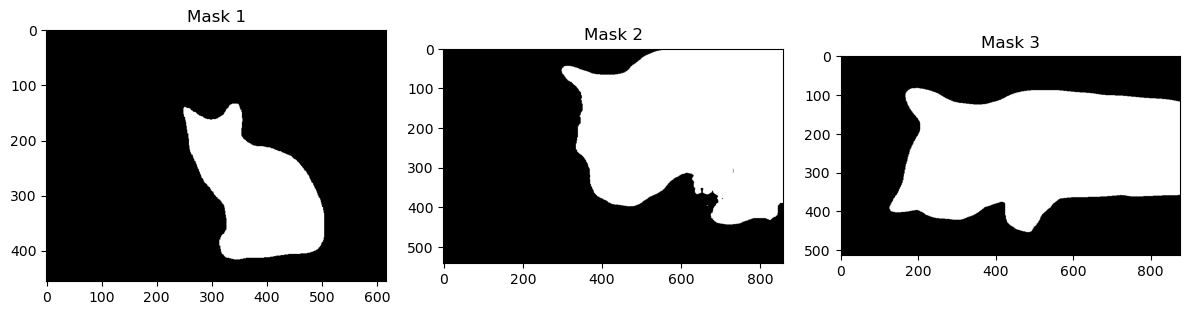

In [31]:
target_class_id1 = unique_classes1[-1]

seg_map1 = (output_predictions_resized1 == target_class_id1)
img_mask1 = seg_map1.astype(np.uint8) * 255

target_class_id2 = unique_classes2[-1]

seg_map2 = (output_predictions_resized2 == target_class_id2)
img_mask2 = seg_map2.astype(np.uint8) * 255

target_class_id3 = unique_classes3[-1]

seg_map3 = (output_predictions_resized3 == target_class_id3)
img_mask3 = seg_map3.astype(np.uint8) * 255

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img_mask1, cmap='gray')
plt.title("Mask 1")

plt.subplot(1,3,2)
plt.imshow(img_mask2, cmap='gray')
plt.title("Mask 2")

plt.subplot(1,3,3)
plt.imshow(img_mask3, cmap='gray')
plt.title("Mask 3")

plt.tight_layout()
plt.show()

In [32]:
# 배경을 고양이 이미지 크기에 맞춤
sand_img_resized1 = cv2.resize(sand_img, (cat_img1.shape[1], cat_img1.shape[0]))
sand_img_resized2 = cv2.resize(sand_img, (cat_img2.shape[1], cat_img2.shape[0]))
sand_img_resized3 = cv2.resize(sand_img, (cat_img3.shape[1], cat_img3.shape[0]))

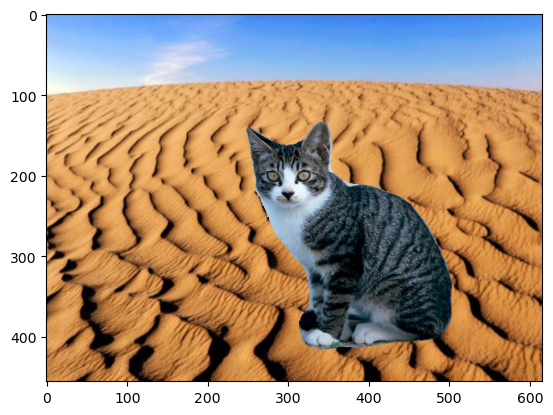

In [33]:
# 고양이 부분만 남기고 배경 적용
img_mask_color1 = cv2.cvtColor(img_mask1, cv2.COLOR_GRAY2BGR)  # 3채널 변환
result_img = np.where(img_mask_color1 == 255, cat_img1, sand_img_resized1)  # 마스크 기반 합성

plt.imshow(result_img)
plt.show()

### Step 2 -1, 고양이 사진 1에서 문제점 찾기
- 고양이 사진 1은 고양이 다리와 다리 사이의 공간이 blur가 되지 않았음.
- 발 밑도 마찬가지임
- Semantic segmentation 모델이 얇은 구조(다리 사이 공간)를 정확히 분리하지 못함.

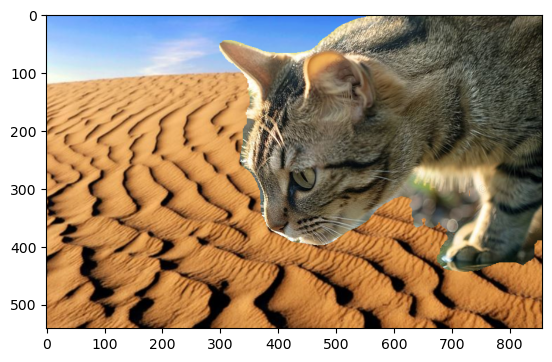

In [35]:
# 고양이 부분만 남기고 배경 적용
img_mask_color2 = cv2.cvtColor(img_mask2, cv2.COLOR_GRAY2BGR)  # 3채널 변환
result_img2 = np.where(img_mask_color2 == 255, cat_img2, sand_img_resized2)  # 마스크 기반 합성

plt.imshow(result_img2)
plt.show()

### Step 2 - 2, 고양이 사진 2에서 문제점 찾기
- 고양이 사진 2는 배경인 풀숲이 정확하게 blur 처러 안됐음(귀 밑, 얼굴 외곽)
- 목 밑 부분도과 발 밑도 마찬가지임
- 객체 경계에서 segmentation mask 정밀도가 낮음

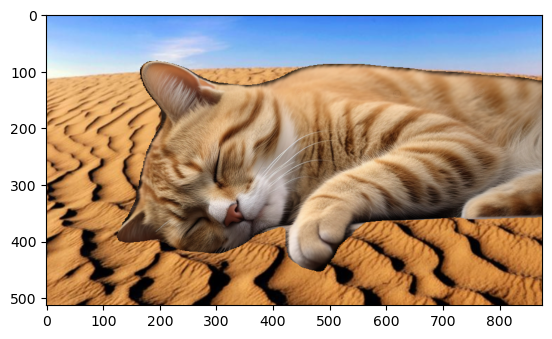

In [36]:
# 고양이 부분만 남기고 배경 적용
img_mask_color3 = cv2.cvtColor(img_mask3, cv2.COLOR_GRAY2BGR)  # 3채널 변환
result_img3 = np.where(img_mask_color3 == 255, cat_img3, sand_img_resized3)  # 마스크 기반 합성

plt.imshow(result_img3)
plt.show()

### Step 2 -3 고양이 사진 3에서 문제점 찾기
- 고양이 사진 3은 외발 밑이 blur 처리가 부족함
- 왼 다리와 배경(목재) 사이 처리가 안됐음
- 배경과 색상이 유사한 영역에서 segmentation 오류 발생

### Step 2 사진에서 문제점 찾기 정리
- 사진 이미지에서 다리 사이 틈, 발 밑, 귀·얼굴 외곽, 배경 풀숲 등은  마스크가 얇아서 경계/구멍을 놓치거나나,
- 경계가 들쭉날쭉해서 전경인 고양이와 배경이 섞이는 현상이 나타남. 
- DeepLab의 semantic segmentation이 “클래스 단위”로 대략적인 영역을 잘라주지만, 미세 경계·가느다란 부위·빈 공간을 완벽히 복원하긴 어렵기 때문에 발생

### Step 3 해결 방법 제안해 보기

### 1. 문제 원인 분석
- Semantic segmentation 방식은 픽셀 단위로 객체를 분류하지만 다음과 같은 한계가 존재한다.
#### 1.1 경계 인식 오류
- 털, 귀, 다리 같은 얇은 구조 인식이 어려움
- 객체 경계에서 foreground와 background 혼합 발생

#### 1.2 구조적 공간 인식 한계
- 다리 사이와 같은 빈 공간(hole) 영역을 정확히 분리하지 못함

#### 1.3 깊이 정보 부족
- Semantic segmentation은 객체 종류만 분류
- 실제 카메라 인물모드는 거리(depth)를 기반으로 blur 적용

### 4. 문제 해결 솔루션 제안
 - 해결 방안 1 : Morphological 연산 기반 Mask 보정
#### 적용 기술
- Closing 연산
- Hole Filling
#### 적용 메커니즘
- Semantic segmentation 결과 마스크에 Morphological 연산을 적용하여
- 끊어진 객체 경계를 연결
- 다리 사이 빈 공간 제거
- 발 아래 누락 영역 보완

#### 기대 효과
- 객체 구조 안정성 향상

segmentation mask 연결성 개선

#### 해결방안 2 : Soft Mask 및 Feathering 적용
#### 적용 기술
- Gaussian Blur 기반 Soft Mask 생성
- Alpha Blending 합성
#### 적용 메커니즘
- Binary Mask를 직접 사용하는 대신 경계 영역을 점진적으로 전환하여
- 털 끝 및 얼굴 외곽 경계 부드럽게 처리
- 경계 artifact 감소

#### 기대 효과
- 자연스러운 합성 이미지 생성
- 실제 광학 보케 효과 유사 구현

#### 해결방안 3 : Depth 기반 가변 Blur 적용
#####  적용 기술
- 단안 Depth Estimation 모델 활용
- Depth 기반 Blur Kernel 적용

##### 적용 메커니즘
- Depth 정보를 활용하여
- 피사체 근접 배경은 약한 Blur
- 먼 배경은 강한 Blur 적용

##### 기대 효과
- 실제 카메라 피사계 심도 구현
- 경계 부자연스러움 감소

#### 헤걀방안 4 : Instance Segmentation 모델 적용
##### 적용 기술
- Mask R-CNN 기반 객체 분리

#### 적용 메커니즘
- Semantic segmentation이 아닌 객체 단위 segmentation 적용으로
- 객체 경계 정확도 향상
- 다중 객체 상황에서도 안정적 분리 가능

## 회고

- 이번 프로젝트를 진행하면서 인물모드와 배경 Blur 기술이 단순한 사진 효과를 넘어 다양한 시각 서비스에서 활용된다는 점을 이해할 수 있었다. 
- 특히 Zep, Zoom, Google Meet과 같은 온라인 협업 도구에서도 얼굴과 신체 영역만 유지하고 배경을 흐리게 처리하는 기술이 적극적으로 활용되고 있다는 점이 인상적이었다. 
- 직접 Semantic Segmentation 모델을 적용해 보면서 이러한 기술이 딥러닝 기반으로 구현된다는 것을 체감할 수 있었다.

- 하지만 실제 결과를 제작해 보니 객체 경계 부분이나 얇은 구조 영역에서 마스크 정확도가 떨어지는 문제가 발생하였다. 
- 이를 통해 상용 서비스에서 자연스러운 Blur 효과를 구현하기 위해서는 단순 segmentation만으로는 부족하며 후처리 기술이나 Depth 정보 활용이 중요하다는 점을 알게 되었다.

- 또한 실제 사용자 환경에서는 정확도뿐만 아니라 실시간 처리 성능과 안정성이 매우 중요하다는 점도 깨달았다. 
- 이번 프로젝트를 통해 컴퓨터 비전 기술이 실생활 서비스와 밀접하게 연결되어 있다는 것을 경험할 수 있었으며, 
- 앞으로는 더욱 정교한 객체 분리 기술과 다양한 멀티모달 기술을 함께 학습하고 싶다는 목표를 갖게 되었다.